In [1]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.1 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=70b23d3352cc882106966a49ac71fb8d03f2ab5c6bd4d59252fb0b4a4b57de8f
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [2]:
import tensorflow as tf 
from sentence_transformers import SentenceTransformer


## for data
import pandas as pd
import numpy as np
import re
import os
import glob
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss, classification_report, ConfusionMatrixDisplay,confusion_matrix
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from pathlib import Path

import torch
# import gradio as gr
from tqdm import tqdm
from time import sleep

from typing import Dict, List, Tuple
import codecs
from text_unidecode import unidecode

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_colwidth = 6000

Reading Traning data

In [5]:
import gc
gc.collect()

30

In [6]:
def read_data(path:str, file_type:str)-> pd.DataFrame:
    if glob.glob(path+file_type+".csv"):
        df = pd.read_csv(path+file_type+".csv")
    
    essay_dict = {}
    for file in glob.glob(path+file_type+'/*.txt'): 
        with open(file, "r") as file_open:
            filename = file.split(file_type+'/')[1].split('.txt')[0]
            essay_dict[filename] = file_open.read()
        
    essay_data = pd.DataFrame.from_dict([essay_dict]).T.reset_index()
    essay_data.columns = ["essay_id", "essay_text"]
    train_data = pd.merge(df,essay_data,left_on = 'essay_id', right_on ='essay_id', how ='left')
    print(file_type+" data: ",train_data.shape)
    return train_data

### Reading Train data

In [7]:
filepath = '/content/drive/MyDrive/fourthbrain/Effective_Writing_Feedback/data/'
train_data = read_data(filepath, 'train')
test_data = read_data(filepath, 'test')


train data:  (36765, 6)
test data:  (21, 5)


In [8]:
AUTO = tf.data.experimental.AUTOTUNE
# Configuration
EPOCHS = 10
BATCH_SIZE = 16
MAX_LEN = 256
MODEL_TYPE="sentence"
TOKENIZERS_PARALLELISM= False

## Cleaning textual data

In [9]:
# https://www.kaggle.com/competitions/feedback-prize-2021/discussion/313330
def replace_encoding_with_utf8(error: UnicodeError) -> Tuple[bytes, int]:
    return error.object[error.start : error.end].encode("utf-8"), error.end


def replace_decoding_with_cp1252(error: UnicodeError) -> Tuple[str, int]:
    return error.object[error.start : error.end].decode("cp1252"), error.end

# Register the encoding and decoding error handlers for `utf-8` and `cp1252`.
codecs.register_error("replace_encoding_with_utf8", replace_encoding_with_utf8)
codecs.register_error("replace_decoding_with_cp1252", replace_decoding_with_cp1252)

def resolve_encodings_and_normalize(text: str) -> str:
    """Resolve the encoding problems and normalize the abnormal characters."""
    text = (
        text.encode("raw_unicode_escape")
        .decode("utf-8", errors="replace_decoding_with_cp1252")
        .encode("cp1252", errors="replace_encoding_with_utf8")
        .decode("utf-8", errors="replace_decoding_with_cp1252")
    )
    text = unidecode(text)
    return text

In [12]:
def cleanup_text(text):
    punctuation_signs = list("?:!,;")
    text = text.replace("\n","")
    text = text.replace("\r", " ")
    text = text.replace("    ", " ")
    text = text.replace('"', '')
    text = text.replace("'s", "")
    for punct_sign in punctuation_signs:
      text = text.replace(punct_sign, '')
    words = re.sub(pattern = '[^a-zA-Z]',repl = ' ', string = text)
    words = words.lower()
    return words


train_data['processed_discourse'] = train_data['discourse_text'].apply(cleanup_text)
train_data['processed_essay'] = train_data['essay_text'].apply(cleanup_text)


# test_data['normalized_discourse'] = test_data['discourse_text'].apply(resolve_encodings_and_normalize)
# test_data['processed_discourse'] = test_data['normalized_discourse'].apply(cleanup_text)

# test_data['processed_essay'] = test_data['essay_text'].apply(resolve_encodings_and_normalize)
# test_data['processed_essay'] = test_data['processed_essay'].apply(cleanup_text)
# display(test_data[test_data['discourse_id'] == '84942fc2ab0f'].head(1))

In [13]:
tokenizer = SentenceTransformer('sentence-transformers/sentence-t5-xl')

In [14]:
train_data['inputs'] = train_data.discourse_type + ' ' +train_data.discourse_text
# train_data['infloat_inputs'] = "query: "+train_data.discourse_type+" "+train_data.discourse_text

train_data.head(1)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,essay_text,processed_discourse,processed_essay,inputs
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform.",Lead,Adequate,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform\n\nI think that the face is a natural landform because there is no life on Mars that we have descovered yet. If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, ""It's not easy to target Cydonia,"" in which he is saying that its not easy to know if it is a natural landform at this point. In all that they're saying, its probably a natural landform.\n\nPeople thought that the face was formed by alieans because they thought that there was life on Mars. though some say that life on Mars does exist, I think that there is no life on Mars.\n\nIt says in paragraph 7, on April 5, 1998, Mars Global Surveyor flew over Cydonia for the first time. Michael Malin took a picture of Mars with his Orbiter Camera, that the face was a natural landform. Everyone who thought it was made by alieans even though it wasn't, was not satisfied. I think they were not satisfied because they have thought since 1976 that it was really formed by alieans.\n\nThough people were not satified about how the landform was a natural landform, in all, we new that alieans did not form the face. I would like to know how the landform was formed. we know now that life on Mars doesn't exist.",hi i m isaac i m going to be writing about how this face on mars is a natural landform or if there is life on mars that made it the story is about how nasa took a picture of mars and a face was seen on the planet nasa doesn t know if the landform was created by life on mars or if it is just a natural landform,hi i m isaac i m going to be writing about how this face on mars is a natural landform or if there is life on mars that made it the story is about how nasa took a picture of mars and a face was seen on the planet nasa doesn t know if the landform was created by life on mars or if it is just a natural landform on my perspective i think that the face is a natural landform because i dont think that there is any life on mars in these next few paragraphs i ll be talking about how i think that is is a natural landformi think that the face is a natural landform because there is no life on mars that we have descovered yet if life was on mars we would know by now the reason why i think it is a natural landform because nobody live on mars in order to create the figure it says in paragraph it not easy to target cydonia in which he is saying that its not easy to know if it is a natural landform at this point in all that they re saying its probably a natural landform people thought that the face was formed by alieans because they thought that there was life on mars though some say that life on mars does exist i think that there is no life on mars it says in paragraph on april mars global surveyor flew over cydonia for the first time michael malin took a picture of mars with his orbiter camera that the face was a natural landform everyone who thought it was made by alieans

In [15]:
bin_map = {"Ineffective": 0, "Adequate": 1, "Effective": 2}
train_data['label'] = train_data['discourse_effectiveness'].map(bin_map)
train_data.head(1)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,essay_text,processed_discourse,processed_essay,inputs,label
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform.",Lead,Adequate,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform\n\nI think that the face is a natural landform because there is no life on Mars that we have descovered yet. If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, ""It's not easy to target Cydonia,"" in which he is saying that its not easy to know if it is a natural landform at this point. In all that they're saying, its probably a natural landform.\n\nPeople thought that the face was formed by alieans because they thought that there was life on Mars. though some say that life on Mars does exist, I think that there is no life on Mars.\n\nIt says in paragraph 7, on April 5, 1998, Mars Global Surveyor flew over Cydonia for the first time. Michael Malin took a picture of Mars with his Orbiter Camera, that the face was a natural landform. Everyone who thought it was made by alieans even though it wasn't, was not satisfied. I think they were not satisfied because they have thought since 1976 that it was really formed by alieans.\n\nThough people were not satified about how the landform was a natural landform, in all, we new that alieans did not form the face. I would like to know how the landform was formed. we know now that life on Mars doesn't exist.",hi i m isaac i m going to be writing about how this face on mars is a natural landform or if there is life on mars that made it the story is about how nasa took a picture of mars and a face was seen on the planet nasa doesn t know if the landform was created by life on mars or if it is just a natural landform,hi i m isaac i m going to be writing about how this face on mars is a natural landform or if there is life on mars that made it the story is about how nasa took a picture of mars and a face was seen on the planet nasa doesn t know if the landform was created by life on mars or if it is just a natural landform on my perspective i think that the face is a natural landform because i dont think that there is any life on mars in these next few paragraphs i ll be talking about how i think that is is a natural landformi think that the face is a natural landform because there is no life on mars that we have descovered yet if life was on mars we would know by now the reason why i think it is a natural landform because nobody live on mars in order to create the figure it says in paragraph it not easy to target cydonia in which he is saying that its not easy to know if it is a natural landform at this point in all that they re saying its probably a natural landform people thought that the face was formed by alieans because they thought that there was life on mars though some say that life on mars does exist i think that there is no life on mars it says in paragraph on april mars global surveyor flew over cydonia for the first time michael malin took a picture of mars with his orbiter camera that the face was a natural landform everyone who thought it was made by a

In [16]:
train_data.label.value_counts()

1    20977
2     9326
0     6462
Name: label, dtype: int64

### Splitting dataset into train and validation dataset.

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_data['inputs'], train_data['label'], test_size=0.1, random_state=42,\
                                                      stratify=train_data["label"])


In [19]:
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(33088,) (33088,) (3677,) (3677,)


Generate Training and Validation Dataset

In [ ]:
# train_dataset = tokenizer.encode(X_train.to_list())
# valid_dataset = tokenizer.encode(X_valid.to_list())

In [ ]:
# emb_train = np.array(train_dataset)
# emb_valid = np.array(valid_dataset)

Saved into a pickle file for further tests

In [ ]:
# import pickle

# with open('/content/drive/MyDrive/fourthbrain/Effective_Writing_Feedback/data/emb_train.pickle', "wb") as f:
#   pickle.dump(emb_train, f)

# with open('/content/drive/MyDrive/fourthbrain/Effective_Writing_Feedback/data/emb_valid.pickle', "wb") as f:
#   pickle.dump(emb_valid, f)


# with open('doc_embedding.pickle', 'rb') as pkl:
#     doc_embedding = pickle.load(pkl)


Read from saved pickle file

In [20]:
import pickle
with open('/content/drive/MyDrive/fourthbrain/Effective_Writing_Feedback/data/emb_train.pickle', 'rb') as pkl:
    emb_train = pickle.load(pkl)

with open('/content/drive/MyDrive/fourthbrain/Effective_Writing_Feedback/data/emb_valid.pickle', 'rb') as pkl:
  emb_valid = pickle.load(pkl)

In [ ]:
# Encode the target variable as categorical with one-hot encoding
# le = LabelEncoder()
# y_train = le.fit_transform(train_data['discourse_effectiveness'])

In [92]:
import gc
gc.collect()


24417

Add Class weights

In [22]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert class weights to a dictionary for passing to fit method
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: 1.896377808344796, 1: 0.5842117343785864, 2: 1.3141109654871124}


In [65]:
sample_weights = [class_weights[label] for label in y_train]
len(sample_weights)

33088

# **XGB Classifier**

In [39]:
# Train an XGBoost model with grid search cross-validation
xgb_model = xgb.XGBClassifier(objective='multi:softmax')


In [93]:
xgb_model.fit(emb_train, y_train, eval_metric='mlogloss', sample_weight = sample_weights)
# xgb_model.fit(emb_train, y_train, eval_metric='mlogloss')

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softmax', predictor=None, ...)

Save model to a pickle file

In [110]:
import pickle
pickle.dump(xgb_model, open('/content/drive/MyDrive/fourthbrain/Effective_Writing_Feedback/data/st_xgb_0505.pkl', 'wb'))

Load model for further clarifications

In [95]:
# import pickle
# xgb_model = pickle.load(open('/content/drive/MyDrive/fourthbrain/Effective_Writing_Feedback/data/st_xgb.pkl', 'rb'))

In [96]:
# Encode the target variable as categorical with one-hot encoding
le = LabelEncoder()

# Print the best hyperparameters found by grid search
# print("Best hyperparameters:", grid_search.best_params_)

# Make predictions on the validation data using the best model
y_pred = xgb_model.predict(emb_valid)


# Evaluate the performance of the model
accuracy = np.mean(y_pred == y_valid)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.63


In [97]:
output_df = pd.DataFrame(zip(y_valid, y_pred), columns=["true_label","predicted_label"])
bin_map = {0:"Ineffective", 1:"Adequate", 2:"Effective"}
output_df["true_label_class"] = output_df["true_label"].map(bin_map)
output_df["predicted_label_class"] = output_df["predicted_label"].map(bin_map)
output_df.head()

,true_label,predicted_label,true_label_class,predicted_label_class
0,2,2,Effective,Effective
1,1,2,Adequate,Effective
2,1,1,Adequate,Adequate
3,1,1,Adequate,Adequate
4,1,1,Adequate,Adequate


In [98]:
output_df['true_label'].unique()

array([2, 1, 0])

In [99]:
output_df['predicted_label'].unique()

array([2, 1, 0], dtype=int32)

In [100]:
pred = xgb_model.predict_proba(emb_valid)
eval = log_loss(y_valid,pred) 

In [101]:
print("log loss:",eval)

log loss: 0.7789619900121025


In [102]:
classes = output_df.true_label.unique()
labels = output_df.true_label_class.unique()

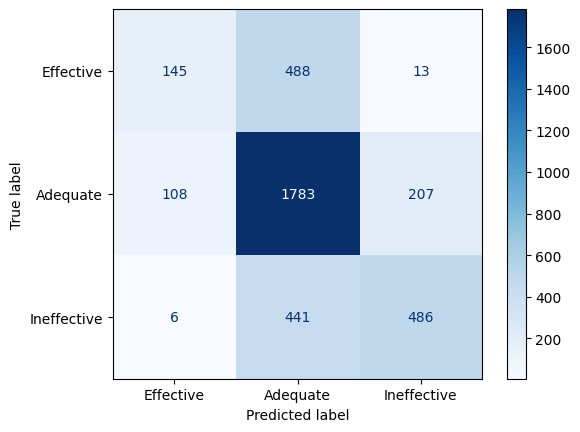

In [85]:
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred, display_labels=labels, cmap=plt.cm.Blues)

In [86]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_valid, y_pred)
print(cf_matrix)

[[ 145  488   13]
 [ 108 1783  207]
 [   6  441  486]]


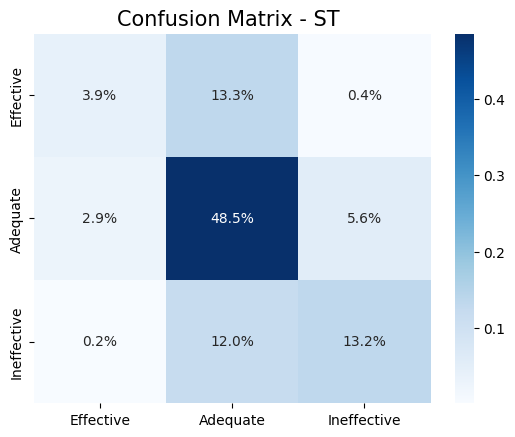

In [103]:
plt.title("Confusion Matrix - ST ", fontsize =15)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.1%', cmap='Blues', xticklabels=labels, yticklabels=labels)
figure = ax.get_figure()    
figure.savefig('/content/drive/MyDrive/fourthbrain/Effective_Writing_Feedback/st_xgb_cm_w_weights.png')

In [105]:
print(classification_report(output_df['true_label'], output_df['predicted_label'], target_names = labels))

              precision    recall  f1-score   support

   Effective       0.45      0.47      0.46       646
    Adequate       0.70      0.68      0.69      2098
 Ineffective       0.62      0.63      0.63       933

    accuracy                           0.63      3677
   macro avg       0.59      0.60      0.59      3677
weighted avg       0.64      0.63      0.63      3677



In [106]:
print(classification_report(output_df['true_label'], output_df['predicted_label'], target_names = labels))

              precision    recall  f1-score   support

   Effective       0.45      0.47      0.46       646
    Adequate       0.70      0.68      0.69      2098
 Ineffective       0.62      0.63      0.63       933

    accuracy                           0.63      3677
   macro avg       0.59      0.60      0.59      3677
weighted avg       0.64      0.63      0.63      3677



In [107]:
y_prob = xgb_model.predict_proba(emb_valid)

# Compute the AUC-ROC score
auc_roc = roc_auc_score(y_valid, y_prob, multi_class='ovr')

In [108]:
auc_roc

0.7866332858617094

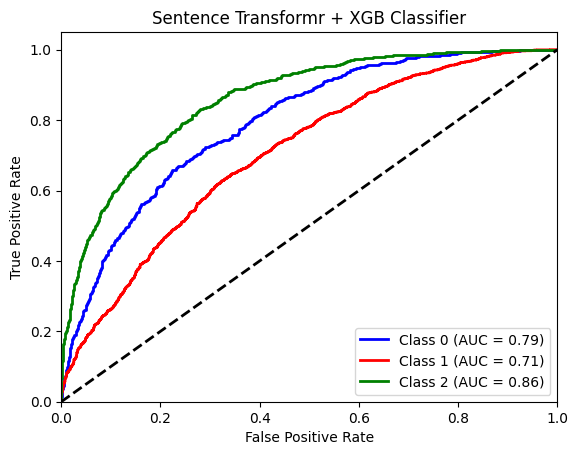

In [115]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Plot the AUC-ROC curve
fpr = {}
tpr = {}
roc_auc = {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_valid == i, y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['blue', 'red', 'green']
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Sentence Transformr + XGB Classifier')
plt.legend(loc="lower right")
# plt.show()
plt.savefig('/content/drive/MyDrive/fourthbrain/Effective_Writing_Feedback/st_auc_roc_curve.png',bbox_inches='tight')

'/content'